In [ ]:
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import skimage
from skimage.io import imread
from skimage.transform import resize
from skimage import exposure
import cv2


images_dir = Path('/content/drive/MyDrive/kaggle/rice/ricedisease')
folders = [directory for directory in images_dir.iterdir() if directory.is_dir()]
categories = [fo.name for fo in folders]

images = []
target = []
target_names=categories

for i, direc in enumerate(folders):
  for file in direc.iterdir():
    img = skimage.io.imread(file)
    img = resize(img, (224, 224))
    images.append(img)
    target.append(i)

target = np.array(target)
images = np.array(images)

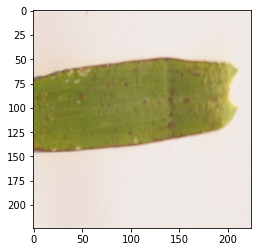

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, target, test_size=0.3,random_state=109)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)


In [ ]:
dataAugmentaion = ImageDataGenerator(rotation_range = 40, zoom_range = 0.20, 
fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
width_shift_range = 0.2, height_shift_range = 0.2)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


In [ ]:
history=model.fit_generator(dataAugmentaion.flow(X_train, y_train, batch_size = 16),
 validation_data = (X_test, y_test), steps_per_epoch = len(X_train) // 16,
 epochs = 50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
7/7 [==============================] - 24s 3s/step - loss: 4.7646 - accuracy: 0.2117 - val_loss: 0.6471 - val_accuracy: 0.8200
Epoch 2/50
7/7 [==============================] - 18s 3s/step - loss: 0.9470 - accuracy: 0.6453 - val_loss: 0.5355 - val_accuracy: 0.7600
Epoch 3/50
7/7 [==============================] - 16s 2s/step - loss: 0.7159 - accuracy: 0.7832 - val_loss: 0.4172 - val_accuracy: 0.8000
Epoch 4/50
7/7 [==============================] - 16s 2s/step - loss: 0.6591 - accuracy: 0.7696 - val_loss: 0.4086 - val_accuracy: 0.8000
Epoch 5/50
7/7 [==============================] - 17s 2s/step - loss: 0.2756 - accuracy: 0.8945 - val_loss: 0.2764 - val_accuracy: 0.9000
Epoch 6/50
7/7 [==============================] - 16s 2s/step - loss: 0.2726 - accuracy: 0.9000 - val_loss: 0.3632 - val_accuracy: 0.8200
Epoch 7/50
7/7 [==============================] - 18s 3s/step - loss: 0.3372 - accuracy: 0.8471 - val_loss: 0.2347 - val_accuracy: 0.8800
Epoch 8/50
7/7 [==================

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model.save('inception_model.h5')

In [ ]:
y_pred = model.predict(X_test)
print("Predicted values:")
print(y_pred)

Predicted values:
[[9.29147632e-07 3.17176870e-07 1.02650572e-03 9.98972297e-01]
 [9.99945045e-01 1.83412776e-05 6.66019240e-09 3.65539563e-05]
 [1.16797537e-06 3.05402955e-06 9.98048186e-01 1.94760796e-03]
 [9.99999762e-01 2.18257043e-07 6.57117277e-11 5.88298192e-08]
 [1.40359447e-07 6.05778005e-05 9.99325156e-01 6.14088378e-04]
 [6.36881232e-01 1.35703593e-01 5.92905562e-03 2.21486121e-01]
 [9.99504089e-01 5.67421666e-05 6.43684928e-08 4.39108291e-04]
 [9.53403685e-08 9.99913096e-01 7.58942633e-06 7.91794737e-05]
 [4.53794892e-05 7.47205049e-05 2.04518475e-02 9.79427993e-01]
 [8.27005842e-09 9.99998093e-01 5.02823099e-08 1.87371813e-06]
 [4.53755561e-10 9.99999523e-01 2.20065544e-07 2.36042055e-07]
 [8.07549554e-07 2.71573072e-07 1.47487712e-03 9.98524010e-01]
 [6.66403912e-06 9.99992609e-01 3.16055377e-08 7.61067611e-07]
 [1.03387833e-02 4.40161467e-01 1.45736604e-03 5.48042357e-01]
 [1.00000000e+00 3.47823020e-10 1.38851832e-12 1.65352994e-08]
 [1.49040863e-10 9.99999881e-01 1.704

In [ ]:
import cv2
import itertools
import random
from collections import Counter
from glob import iglob
import os


def load_image(filename):
    img = cv2.imread(os.path.join(filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    
    return img

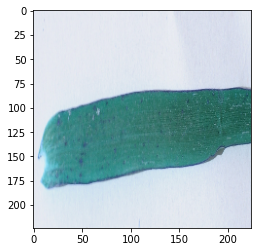

Predicted Disease is Leaf smut


In [ ]:
import matplotlib.pyplot as plt


%matplotlib inline
img = load_image('/content/drive/MyDrive/kaggle/rice/newricedisease/Leaf Smut/Copy of DSC_0310.JPG')
p = model.predict(np.asarray([img]))[0]
plt.imshow(img)    
plt.show()
k = target_names
class_idx = np.argmax(p)
s = [str(i) for i in p] 
a = int(class_idx) 
print("Predicted Disease is", k[a])